# Set Up

In [1]:
#load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_ind
import usefulFunctions as uf
import numpy as np
from scipy.stats import pearsonr

In [2]:
#set paths
current_directory = os.getcwd()
base_dir = f'{os.path.dirname(current_directory)}/'
data_dir = f'{base_dir}Source_Data/'
fig_dir = f'{base_dir}/figures/'

In [3]:
# set color palettes and variable order
ses_palette = {
    'ses-1': '#440154',
    'ses-2': '#414487', 
    'ses-3': '#2a788e',
    'ses-4': '#22a884',
    'ses-5': '#7ad151'}

dysGroup_palette = {
    'dyslexic': '#8E44AD',
    'typical': '#BB8FCE'}

subGroup_palette = {
    'intervention': '#CD5C5C',
    'dyslexic control': '#D8BFD8',
    'typical control': '#ADD8E6'
}

# set session order
sessions = ['ses-1','ses-2','ses-3','ses-4','ses-5']

# set roi order
rois = ['VWFA1','VWFA2','FFA1','FFA2']

#select assessments variables
assessments = ['wj_brs', 'wj_rf', 'twre_index', 'wj_mff_ss']

# Define assessment titles
titles = {
    'wj_brs': 'WJ BRS',
    'wj_rf': 'WJ RF',
    'twre_index': 'TOWRE Index',
    'wj_mff_ss': 'WJ MFF'
}

# Baseline Selectivity

### Figure 2f

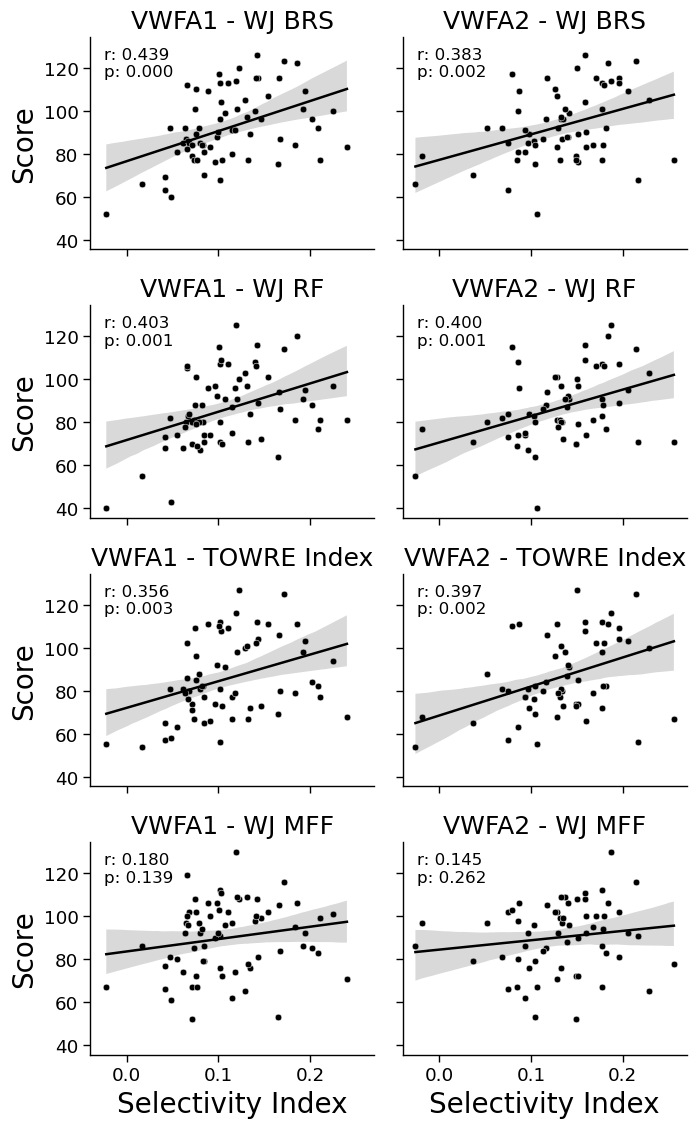

In [7]:
save_fig = False
sns.set_theme(context='paper', style=None, font_scale=1.5)

#read in data
plot_df = pd.read_csv(f'{data_dir}fig_2f.csv')

# Create a FacetGrid
g = sns.FacetGrid(plot_df, row='assessment', col='roi', height=3, aspect=1.2, palette=list(dysGroup_palette.values()))

# Map the scatterplot and regplot onto the FacetGrid
g.map(sns.scatterplot, 'text_selectivity', 'score', color='black')
g.map(sns.regplot, 'text_selectivity', 'score', scatter=False, color='black')

# Apply the annotation function to each subplot
g.map_dataframe(uf.annotate_regression_corr,x_param='text_selectivity',y_param='score',fontsize=12)

# Set uniform x and y-axis labels
g.set_axis_labels('Selectivity Index', 'Score', size=20)

# Define custom titles for each subplot
titles = {
    'wj_brs': 'WJ BRS',
    'wj_rf': 'WJ RF',
    'twre_index': 'TOWRE Index',
    'wj_mff_ss': 'WJ MFF'
}
rois = ['VWFA1', 'VWFA2']

#Set titles and labels for each subplot
for i, assessment in enumerate(assessments):
    for j, roi in enumerate(rois):
        ax = g.axes[i, j]
        ax.set_title(f'{roi} - {titles[assessment]}', size=18)

# Adjust layout to ensure labels are visible
plt.tight_layout(rect=[0, 0, 1, 0.96])

if save_fig:
    g.savefig(f'{fig_dir}fig_2f.svg', bbox_inches="tight", transparent=True, dpi=400)

plt.show()


### Tables S5

In [4]:
# load data
df = pd.read_csv(f'{data_dir}tbl_s5.csv')

# create variable to collect results
all_results = []

# loop through rois and assessments
for i, roi in enumerate(np.unique(df['roi'])):
    for j, assessment in enumerate(np.unique(df['assessment'])):

        # filter data
        my_data = df.query('roi==@roi and assessment==@assessment')

        # remove NAs
        my_data = my_data.dropna(axis=0,subset=['score'])

        # run correlations and collect results
        all_results.append({
            'roi':roi,
            'assessment':assessment,
            'r': pearsonr(my_data['text_selectivity'],my_data['score'])[0],
            'ci_low':pearsonr(my_data['text_selectivity'],my_data['score']).confidence_interval()[0],
            'ci_high':pearsonr(my_data['text_selectivity'],my_data['score']).confidence_interval()[1],
            'dof':len(my_data)-2,
            'p':pearsonr(my_data['text_selectivity'],my_data['score'])[1]
        })
# organize results into a df
results_df = pd.DataFrame(all_results)
results_df

,roi,assessment,r,ci_low,ci_high,dof,p
0,VWFA1,twre_index,0.356197,0.124935,0.550749,64,0.003331
1,VWFA1,wj_brs,0.439046,0.225833,0.612119,67,0.000161
2,VWFA1,wj_mff_ss,0.179997,-0.059206,0.399652,67,0.138881
3,VWFA1,wj_rf,0.403147,0.182239,0.585312,66,0.000653
4,VWFA2,twre_index,0.396772,0.156602,0.592639,57,0.001863
5,VWFA2,wj_brs,0.383112,0.147453,0.577609,60,0.002116
6,VWFA2,wj_mff_ss,0.144504,-0.109206,0.380538,60,0.262474
7,VWFA2,wj_rf,0.400115,0.164910,0.592261,59,0.001399


# Longitudinal

## Figure 5b

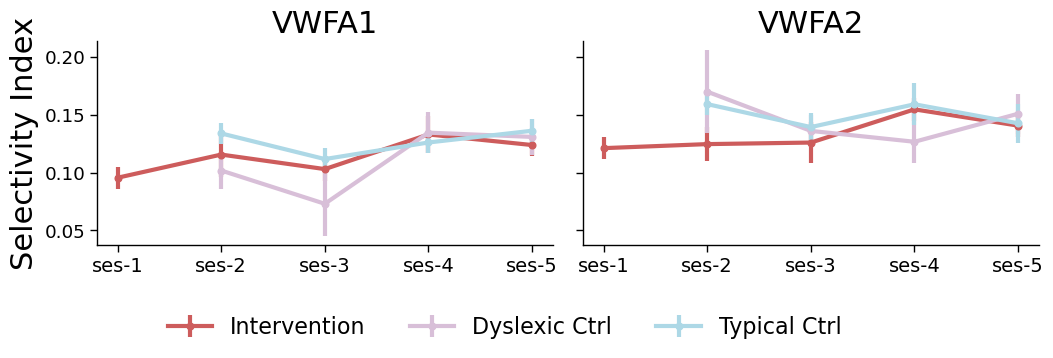

In [10]:
save_fig = False

# read in data
plot_df = pd.read_csv(f'{data_dir}fig_5b.csv')

# Custom color palette
palette = ['#CD5C5C', '#D8BFD8', '#ADD8E6']

# Custom legend labels
legend_labels = {
    'intervention': 'Intervention',
    'dys_control': 'Dyslexic Ctrl',
    'typ_control': 'Typical Ctrl'
}

# Ensure the sessions are in the correct order by sorting the DataFrame
ses_order = ['ses-1', 'ses-2', 'ses-3', 'ses-4', 'ses-5']

# Function to plot with error bars
def plot_with_errorbars(data, color, **kwargs):
    ax = plt.gca()
    for name, group in data.groupby('study_group'):
        group = group.sort_values('ses')
        means = group.groupby('ses', observed=True)['text_selectivity'].mean()
        errors = group.groupby('ses', observed=True)['text_selectivity'].sem()  # Standard error of the mean
        sessions = means.index
        ax.errorbar(sessions, means, yerr=errors, linewidth=3, elinewidth=3, fmt='o-', label=name, color=color)

# Create a FacetGrid
g = sns.FacetGrid(plot_df, col='roi', col_order=rois, hue='study_group', hue_order=['intervention','dys_control','typ_control'], 
                  sharey=True, palette=palette, height=3, aspect=1.8)

# Map the custom plotting function to the grid
g.map_dataframe(plot_with_errorbars)

# Set titles and labels for each subplot
for j, roi in enumerate(rois):
    ax = g.axes[0, j]
    ax.set_title(f'{roi}', size=22)
    ax.tick_params(axis='x', which='major', labelsize=14)  # Ensure tick size is set for each subplot

g.set_axis_labels('', 'Selectivity Index',size=22)

# Customize legend
handles, labels = g._legend_data.values(), g._legend_data.keys()
g.add_legend(title='', bbox_to_anchor=(0.3, 0), loc='upper center', ncol=3, fontsize=16)
for t, l in zip(g.legend.texts, labels):
    t.set_text(legend_labels[l])

# Adjust subplot spacing for better readability
plt.subplots_adjust(top=0.85)

if save_fig:
    plt.savefig(f'{fig_dir}fig_5b.svg', bbox_inches="tight", transparent=True, dpi=400)

# Show the plot
plt.show()
